# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

In [ ]:
import pandas as pd #импортируем Pandas
import numpy as np #импортируем Numpy
import matplotlib.pyplot as plt #импортирем для графиков
from sklearn.model_selection import train_test_split #для разделения выборки
from sklearn.linear_model import LinearRegression #модель линейной регрессии
from sklearn.metrics import mean_squared_error #для MSE 
from catboost import CatBoostRegressor#для CatBoost
from sklearn.model_selection import GridSearchCV #для гинерации автоматически оптимальных параметров
from sklearn.ensemble import RandomForestRegressor #модель случайного леса
from lightgbm import LGBMRegressor as lbm #для LigtBM

In [ ]:
data = pd.read_csv("/datasets/autos.csv") #загружаем файл
data.head() #открываем таблицу

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [ ]:
data.info() #открываем информацию о таблице

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

Данные в порядке, типы данных указаны верно, кроме даты, ее можно было бы привести к типу datatime, однако после обработки пропусков удалим данный столбец, т.к. кореляция скорее всего будет низкой.

In [ ]:
data.isna().sum()

DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Kilometer                0
RegistrationMonth        0
FuelType             32895
Brand                    0
NotRepaired          71154
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

Поговорим о признаках, которые есть в нашей базе данных, кратко пройдемся по описанию каждого из них

* DateCrawled — дата скачивания анкеты из базы
* VehicleType — тип автомобильного кузова
* RegistrationYear — год регистрации автомобиля
* Gearbox — тип коробки передач
* Power — мощность (л. с.)
* Model — модель автомобиля
* Kilometer — пробег (км)
* RegistrationMonth — месяц регистрации автомобиля
* FuelType — тип топлива
* Brand — марка автомобиля
* NotRepaired — была машина в ремонте или нет
* DateCreated — дата создания анкеты
* NumberOfPictures — количество фотографий автомобиля
* PostalCode — почтовый индекс владельца анкеты (пользователя)
* LastSeen — дата последней активности пользователя

Целевой признак - 
* Price — цена (евро)

In [ ]:
y = ["VehicleType", "Gearbox", "Model", "FuelType", "NotRepaired"]
for i in y:
    dolya = data[i].isna().sum() / data[i].shape[0]
    print(f"Доля пропусков для {i} равняется {dolya}")

Доля пропусков для VehicleType равняется 0.1057936783409384
Доля пропусков для Gearbox равняется 0.055967085156997366
Доля пропусков для Model равняется 0.055605879746817584
Доля пропусков для FuelType равняется 0.09282696849893755
Доля пропусков для NotRepaired равняется 0.20079070121822168


С одной стороны, в строках где есть пропуски мы можем удалить пропуски, но целесообразнее будет заменить в категориальных признаках пропуски на моду, та как в некоторых признаках доля пропусков приближается к 10%. Мода - значение переменной величины, которое встречается наиболее часто.

In [ ]:
data["NotRepaired"] = data["NotRepaired"].fillna("no") # меняем на значение ремонта на "no"

In [ ]:
y = ["VehicleType", "Gearbox", "FuelType", "Model"] #выбираем оставшиеся столбцы
for i in y: 
    data[i] = data[i].fillna(data[i].mode()[0]) #заменяем на первое значение массива моды - как самое популярное значение

In [ ]:
data.isna().sum() #проверяем на пропуски

DateCrawled          0
Price                0
VehicleType          0
RegistrationYear     0
Gearbox              0
Power                0
Model                0
Kilometer            0
RegistrationMonth    0
FuelType             0
Brand                0
NotRepaired          0
DateCreated          0
NumberOfPictures     0
PostalCode           0
LastSeen             0
dtype: int64

Перейдем к проверке на дубликаты

In [ ]:
data = data.drop_duplicates() #удаляем дубликаты 
data.shape[0] #сверяем количество строк с исходными (можно было показать это функцией выше)

354364

Приведенные ниже столбцы, на мой взгляд, можно удалить, так как даты, связаны с выгрузкой информации с сайта, а почтовый индекс пользователя необходим для регистрации на сайте.

In [ ]:
pd.to_datetime(data["DateCrawled"]).sort_values() #2016 год значит - дата выгрузки.

329497   2016-03-05 14:06:22
220583   2016-03-05 14:06:23
176823   2016-03-05 14:06:24
99885    2016-03-05 14:06:24
324763   2016-03-05 14:06:24
                 ...        
204218   2016-04-07 14:36:53
53739    2016-04-07 14:36:54
301030   2016-04-07 14:36:55
339649   2016-04-07 14:36:56
90713    2016-04-07 14:36:58
Name: DateCrawled, Length: 354364, dtype: datetime64[ns]

In [ ]:
data = data.drop(["DateCrawled", "DateCreated", "LastSeen", "PostalCode", "RegistrationMonth"], axis = "columns") #удаляем
data.columns #проверяем

Index(['Price', 'VehicleType', 'RegistrationYear', 'Gearbox', 'Power', 'Model',
       'Kilometer', 'FuelType', 'Brand', 'NotRepaired', 'NumberOfPictures'],
      dtype='object')

In [ ]:
data.describe() #числовое описание

,Price,RegistrationYear,Power,Kilometer,NumberOfPictures
count,354364.000000,354364.000000,354364.000000,354364.000000,354364.0
mean,4416.655608,2004.234471,110.093723,128211.373051,0.0
std,4514.159690,90.228593,189.851590,37905.136957,0.0
min,0.000000,1000.000000,0.000000,5000.000000,0.0
25%,1050.000000,1999.000000,69.000000,125000.000000,0.0
50%,2700.000000,2003.000000,105.000000,150000.000000,0.0
75%,6400.000000,2008.000000,143.000000,150000.000000,0.0
max,20000.000000,9999.000000,20000.000000,150000.000000,0.0


Для начала наблюдаю, что изображений в наших данных нет, поэтому предлагаю удалить этот столбец, так как он заполнен нулевыми значениями.

In [ ]:
data["NumberOfPictures"].value_counts() #количество уникальных значений

0    354364
Name: NumberOfPictures, dtype: int64

In [ ]:
data = data.drop("NumberOfPictures", axis = 1) #удаляем столбец и проверяем 
data.columns

Index(['Price', 'VehicleType', 'RegistrationYear', 'Gearbox', 'Power', 'Model',
       'Kilometer', 'FuelType', 'Brand', 'NotRepaired'],
      dtype='object')

Отсортируем значения, чтобы наглядно продемонстрировать о странных значения в годах регистрации машин

In [ ]:
data["RegistrationYear"].value_counts().sort_values() #уникальные значения для года регистрации машины

2290        1
8500        1
2066        1
1039        1
5900        1
        ...  
2006    19900
2001    20123
2005    22109
1999    22727
2000    24490
Name: RegistrationYear, Length: 151, dtype: int64

Хочу отметить, что существуют значения, явно превышающие 2016 год, а так же автомобили 10 века, которых, к сожалению не было, предлагаю машины из будущего переписать на нынешний год, а автомобили "каменного" века 1900 годом, так как в начале 20 века автомобили получают массовый характер, а так же в наших данных могут быть ретро автомобили.

In [ ]:
data = data.query('1990 < = RegistrationYear <= 2016') #срез данных

In [ ]:
data["RegistrationYear"].describe()

count    330165.000000
mean       2003.153193
std           5.642032
min        1990.000000
25%        1999.000000
50%        2003.000000
75%        2007.000000
max        2016.000000
Name: RegistrationYear, dtype: float64

Перейдем к описанию мощности автомобилей.

In [ ]:
data["Power"].describe()

count    330165.000000
mean        111.788282
std         184.345264
min           0.000000
25%          71.000000
50%         105.000000
75%         143.000000
max       20000.000000
Name: Power, dtype: float64

Аналогично, "существует" автомобиль с огромнейшей мощностью, самые высокие значения ограничу самой высокой мощностью автомобиля массмаркета по состоянию на 2016 год.

In [ ]:
data = data.query('Power <= 1800') #срез данных

Далее существуют нулевые значения, которые не должны присутствовать в нашей модели, сделаем срез данных.

In [ ]:
data = data.query('Power > 0') #срез данных
data["Power"].describe()

count    295914.000000
mean        121.646086
std          61.463947
min           1.000000
25%          77.000000
50%         113.000000
75%         150.000000
max        1800.000000
Name: Power, dtype: float64

(0.0, 600.0)

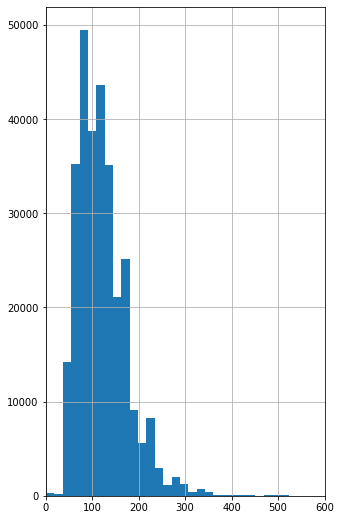

In [ ]:
data['Power'].hist(bins=100, figsize=(5,9)) #график для наглядности
plt.xlim(0,600)

In [ ]:
len(data.loc[data["Power"] == 1]) #столько значений с 1 лошадиной силой, сделаем еще один срез.

27

In [ ]:
data = data.query('Power > 1') #срез данных
data["Power"].describe()

count    295887.000000
mean        121.657095
std          61.455945
min           2.000000
25%          77.000000
50%         113.000000
75%         150.000000
max        1800.000000
Name: Power, dtype: float64

<AxesSubplot:>

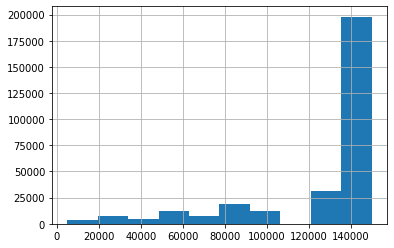

In [ ]:
data["Kilometer"].hist() #пробег

Тут можно заметить, что значения похожи на правду, нет нулевых и запределельных значений, обработка не требуется. Остается крайний шаг в обработке - это переход из категориальных к численным признакам или ONE_HOT_ENCONDING. 

In [ ]:


data.describe()

,Price,RegistrationYear,Power,Kilometer
count,295887.000000,295887.000000,295887.000000,295887.000000
mean,4739.635462,2003.281395,121.657095,128750.942083
std,4608.603786,5.552461,61.455945,36468.638822
min,0.000000,1990.000000,2.000000,5000.000000
25%,1250.000000,1999.000000,77.000000,125000.000000
50%,3000.000000,2003.000000,113.000000,150000.000000
75%,6900.000000,2007.000000,150.000000,150000.000000
max,20000.000000,2016.000000,1800.000000,150000.000000


<AxesSubplot:>

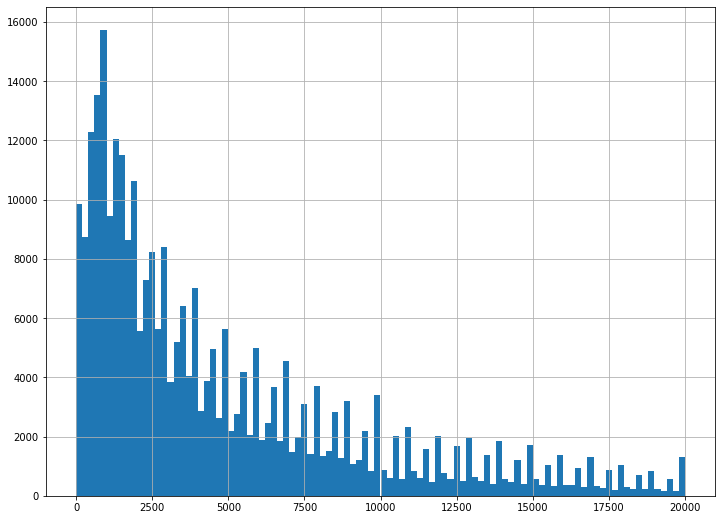

In [ ]:
data['Price'].hist(bins=100, figsize=(12,9)) #для цены видим странные аномалии в 0, предлагаю опять срезать данные

In [ ]:
data = data.query('Price > 0') #срез данных

In [ ]:
data["Price"].describe() #однако есть машины со стоимостью 2,предлагаю взять 5 процентов квантиля

count    289793.000000
mean       4839.304324
std        4604.729779
min           1.000000
25%        1300.000000
50%        3190.000000
75%        6990.000000
max       20000.000000
Name: Price, dtype: float64

In [ ]:
data["Price"].quantile(0.05) 

450.0

In [ ]:
data = data.query('Price > 450') #срез данных по 5% квантилю, который является нижней границей

In [ ]:
#OHE с удалением первоначальных столбцов и сброса индексов для красоты
data_1 = pd.get_dummies(data, drop_first = True).reset_index() 

Можно было сделать еще таким образом, но решил, что это не значительно.

In [ ]:
#data.loc[(data["NotRepaired"] == "no"), "NotRepaired"] = 0 # машина не была в ремонте
#data.loc[(data["NotRepaired"] == "yes"), "NotRepaired"] = 1 #была в ремонте

In [ ]:
#data.loc[(data["Gearbox"] == "manual"), "Gearbox"] = 0 #ручная коробка передач
#data.loc[(data["Gearbox"] == "auto"), "Gearbox"] = 1 #автоматическая коробка

Таким образом, мы загрузили данные, заполнили пропуски, совершили проверку на дубликаты и избавились от них. В рамках задачи избавились от аномальных значений, применили OHE)теперь перейдем к обучению моделей машинного обучения.

## Обучение моделей

Теперь перейдем непосредственно к решению задачи регрессии. В нашем случае - это предсказание по набору признаков цены автомобиля.

Для задачи регрессии будем использовать такие модели, как 
 * LinearRegression
 * CatBoostRegressor
 * RandomForest
 * LGBMRegressor

Разделим датасет на целевой признак и на матрицу признаков.

In [ ]:
target = data_1["Price"] #целевой признак
features = data_1.drop("Price", axis =1 ) #признаки

In [ ]:
features_train, features_test, target_train,target_test = train_test_split(
    features, target, test_size = 0.25, random_state = 12345) #делим на обучающую и тестовую выборку

### LinearRegression

In [ ]:
%%time
model = LinearRegression()
model.fit(features_train, target_train)

CPU times: user 14.6 s, sys: 7.63 s, total: 22.2 s
Wall time: 22.2 s


LinearRegression()

In [ ]:
%%time
predict_y = model.predict(features_test)
#находим метрику RMSE через RSE, для это параметр squared = False
print("Значение RMSE для Линейной Регрессии составляет:", mean_squared_error(target_test, predict_y, squared = False))

Значение RMSE для Линейной Регрессии составляет: 2440.2636363087167
CPU times: user 130 ms, sys: 157 ms, total: 288 ms
Wall time: 294 ms


### CatBoostRegressor

Так как, CatBoost не рекомендует работать с OHE, поскольку это влияет на скорость обучения и на качество прогнозов. Мы просто будем использовать матрицу категориальных признаков.

In [ ]:
target = data["Price"] #целевой признак
features = data.drop("Price", axis = 1) #признаки

In [ ]:
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size = 0.25, random_state = 12345) #делим на обучающую и тестовую выборку

In [ ]:
cat_features = ["VehicleType","Gearbox","Model","FuelType","Brand","NotRepaired"] #категориальные признаки

In [ ]:
model = CatBoostRegressor(random_state = 12345, cat_features = cat_features)
params = [{'learning_rate': [0.01, 0.02, 0.03, 0.04 ],
           "iterations" : [10, 20,30, 40,50],
         'depth':[3,4,5,6]}] #создаем массив с параметрами
best_model = GridSearchCV(model, param_grid=params )#выбираем параметры для модели
#best_model.fit(features_train, target_train) #обучаем ее на тренировочных данных

In [ ]:
%%time
best_model.fit(features_train, target_train)

0:	learn: 4574.2959793	total: 104ms	remaining: 940ms
1:	learn: 4548.6227988	total: 147ms	remaining: 587ms
2:	learn: 4522.9014182	total: 188ms	remaining: 438ms
3:	learn: 4497.7063322	total: 220ms	remaining: 330ms
4:	learn: 4472.7267660	total: 253ms	remaining: 253ms
5:	learn: 4448.2998265	total: 311ms	remaining: 208ms
6:	learn: 4424.3239333	total: 344ms	remaining: 147ms
7:	learn: 4400.1148146	total: 376ms	remaining: 94ms
8:	learn: 4376.9606096	total: 409ms	remaining: 45.4ms
9:	learn: 4353.6204931	total: 447ms	remaining: 0us
0:	learn: 4572.2354761	total: 39.6ms	remaining: 356ms
1:	learn: 4546.5995343	total: 79.9ms	remaining: 320ms
2:	learn: 4520.9396904	total: 115ms	remaining: 269ms
3:	learn: 4495.7751258	total: 147ms	remaining: 220ms
4:	learn: 4471.1248215	total: 178ms	remaining: 178ms
5:	learn: 4446.7592294	total: 217ms	remaining: 145ms
6:	learn: 4422.5665137	total: 251ms	remaining: 107ms
7:	learn: 4398.3875430	total: 283ms	remaining: 70.8ms
8:	learn: 4375.3087353	total: 316ms	remaining

GridSearchCV(estimator=<catboost.core.CatBoostRegressor object at 0x7fce8aa9ceb0>,
             param_grid=[{'depth': [3, 4, 5, 6],
                          'iterations': [10, 20, 30, 40, 50],
                          'learning_rate': [0.01, 0.02, 0.03, 0.04]}])

In [ ]:
%%time
predict_y = best_model.predict(features_test)
#находим метрику RMSE через RSE, для это параметр squared = False
print("Значение RMSE для CatBoostRegression составляет:", mean_squared_error(target_test, predict_y, squared = False))

Значение RMSE для CatBoostRegression составляет: 2148.301568033456
CPU times: user 93.2 ms, sys: 120 µs, total: 93.4 ms
Wall time: 100 ms


### RandomForest

In [ ]:
target = data_1["Price"] #целевой признак
features = data_1.drop("Price", axis =1 ) #признаки

In [ ]:
features_train, features_test, target_train,target_test = train_test_split(
    features, target, test_size = 0.25, random_state = 12345) #делим на обучающую и тестовую выборку

In [ ]:
model = RandomForestRegressor(random_state=12345) #создаем модель
params = [{'max_depth': range(1, 4)}] #создаем массив с параметрами
best_model_tree = GridSearchCV(model, param_grid=params )#выбираем параметры для модели
#best_model_tree.fit(features_train, target_train) #обучаем ее на тренировочных данных


In [ ]:
%%time
best_model_tree.fit(features_train, target_train) #обучаем ее на тренировочных данных

CPU times: user 11min 1s, sys: 4.52 s, total: 11min 5s
Wall time: 11min 6s


GridSearchCV(estimator=RandomForestRegressor(random_state=12345),
             param_grid=[{'max_depth': range(1, 4)}])

In [ ]:
%%time
predict_y = best_model_tree.predict(features_test)
print("Значение RMSE для RandomForest составляет:", mean_squared_error(target_test, predict_y, squared = False))

Значение RMSE для RandomForest составляет: 2852.8554393690706
CPU times: user 322 ms, sys: 74.1 ms, total: 396 ms
Wall time: 416 ms


### LightGBM

In [ ]:
model = lbm()
params = [{'num_leaves':[31], 
                'learning_rate':[0.1, 0.2, 0.3],
                'random_state':[12345]}] # 31 по умолчанию
best_model = GridSearchCV(model, params, scoring='neg_mean_squared_error')#выбираем параметры для модели
#best_model.fit(features_train, target_train) #обучаем ее на тренировочных данных


GridSearchCV(estimator=LGBMRegressor(),
             param_grid=[{'learning_rate': [0.1, 0.2, 0.3], 'num_leaves': [31],
                          'random_state': [12345]}],
             scoring='neg_mean_squared_error')

In [ ]:
%%time
best_model.fit(features_train, target_train) #обучаем ее на тренировочных данных

CPU times: user 1min 33s, sys: 4.78 s, total: 1min 38s
Wall time: 1min 38s


GridSearchCV(estimator=LGBMRegressor(),
             param_grid=[{'learning_rate': [0.1, 0.2, 0.3], 'num_leaves': [31],
                          'random_state': [12345]}],
             scoring='neg_mean_squared_error')

In [ ]:
%%time
predict_y = best_model.predict(features_test)
print("Значение RMSE для LightGBM составляет:", mean_squared_error(target_test, predict_y, squared = False))

Значение RMSE для LightGBM составляет: 1544.383606557889
CPU times: user 582 ms, sys: 106 ms, total: 688 ms
Wall time: 696 ms


## Анализ моделей



Таким образом, мы решили поставленную задачу, теперь перейдем к анализу результатов.
 * Линейная регрессия - время обучения - 20s, предсказание - 208ms, RMSE - 2440.
 * RandomForest - время обучения - 12min 4s, предсказание  - 293ms, RMSE - 2852
 * CatBoostRegressor - время обучения - 12min 20s, время предсказаний - 209ms, RMSE - 2148
 * LightGBM - время обучения - 1min 38s , предсказание - , RMSE - 1745 .

Сводная таблица представлена ниже, где такие модели как CatBoostRegressor и LightGBM дали лучшие результаты по сравнению с остальными моделями, однако скорость обучения LightGBM и RMSE заметно ниже своего аналога.

In [ ]:
table = pd.DataFrame({"name":["LinearRegression", "CatBoostRegressor", "RandomForest", "LightGBM"],
                     "Время обучения" : ["22.2 s", "12min 24s", "11min 6s", "1min 38s"],
                     "Время предсказания" : ["294 ms", "100 ms", "416 ms", "696 ms"],
                     "RMSE" : ["2440","2148","2852","1544"]})
table

,name,Время обучения,Время предсказания,RMSE
0,LinearRegression,22.2 s,294 ms,2440
1,CatBoostRegressor,12min 24s,100 ms,2148
2,RandomForest,11min 6s,416 ms,2852
3,LightGBM,1min 38s,696 ms,1544


В рамках данной работы был проведени такие процессы, как загрузка данных, обработка пропусков, удаление дубликатов,кодирование. Было обучено несколько моделей, что в дальнейшем проанализировать их эффективность во времени и в точности. Был сделан вывод в каких ситуация применим тот или иной алгоритм машинного обучения для нахождения цены автомобиля.